In [1]:
import pymaster as nmt
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import os

These notebooks aim to provide a comprehensive review of the functionality implemented in NaMaster. No rigorous mathematical derivations of any statements made will be provided, and users are referred to the references below for further details:
- **A19**. The original NaMaster paper (Alonso et al. 2019 https://arxiv.org/abs/1809.09603).
- **G19**. Garcia-Garcia et al. 2019 (https://arxiv.org/abs/1906.11765), which introduces the basic approximation used by NaMaster to estimate covariance matrix.
- **N20**. Nicola et al. 2020 (https://arxiv.org/abs/2010.09717), which refined these approximations and described in detail the procedure to estimate cosmic shear power spectra.
- **W24**. Wolz et al. 2024 (https://arxiv.org/abs/2407.21013), which introduced the formalism for catalog-based $C_\ell$s.
- **A24**. Alonso 2024 (https://arxiv.org/abs/2410.07077), which generalised the estimator to anisotropic weights.

# 5 Anisotropic masks <a class="anchor" id="S5"></a>
This short tutorial shows how to use the functionality to account for anisotropic weighting of spin-$s$ fields. In short, anisotropic weighting applies different weights or masks to the different spin component of a field, and even mixes them up. This makes sense when the noise properties of your field are better characterised at every pixel by a covariance matrix that is not proportional to the identity (in which case, it may be appropriate to weight your field by the inverse of this matrix, instead of a simple scalar mask). The application of anisotropic weights causes additional mode coupling between different angular scales and $E/B$ modes, so the mode-coupling coefficients for the power spectra of these fields is also different.

The code below describes one of the tests presented in [Alonso 2024](https://arxiv.org/abs/2410.07077) to validate the implementation of anisotropic weights in NaMaster.

# Table of contents

* [5.1 Simulating anisotropic weights](#Ss5.1)
* [5.2 Validation](#Ss5.2)

## 5.1 Maps and masks <a class="anchor" id="Ss5.1"></a>
For a base mask $m$, we can use the following toy model to generate an anisotropic weighting matrix. We generate the diagonal elements, corresponding to the `11` and `22` weights as $w_{11}=(1+\delta_m)m$ and $w_{22}=(1-\delta_m)m$, where $\delta_m$ is a parameter between -1 and 1. The off-diagonal element is given by $w_{12}=r_m\sqrt{w_{11}w_{22}}$, where the correlation coefficient $r_m$ is defined in the same range. 

Below we construct an anisotropically-weighted field by generating a spin-2 field with power spectra $C_\ell^{EE}=1/(10+\ell)$ and $C_\ell^{BB}=0.2/(10+\ell)$, on which we will apply the mask above with parameters $\delta_m=0.9$ and $r_m=0.5$. We use the same mask used in notebook 3 to construct the base mask here.

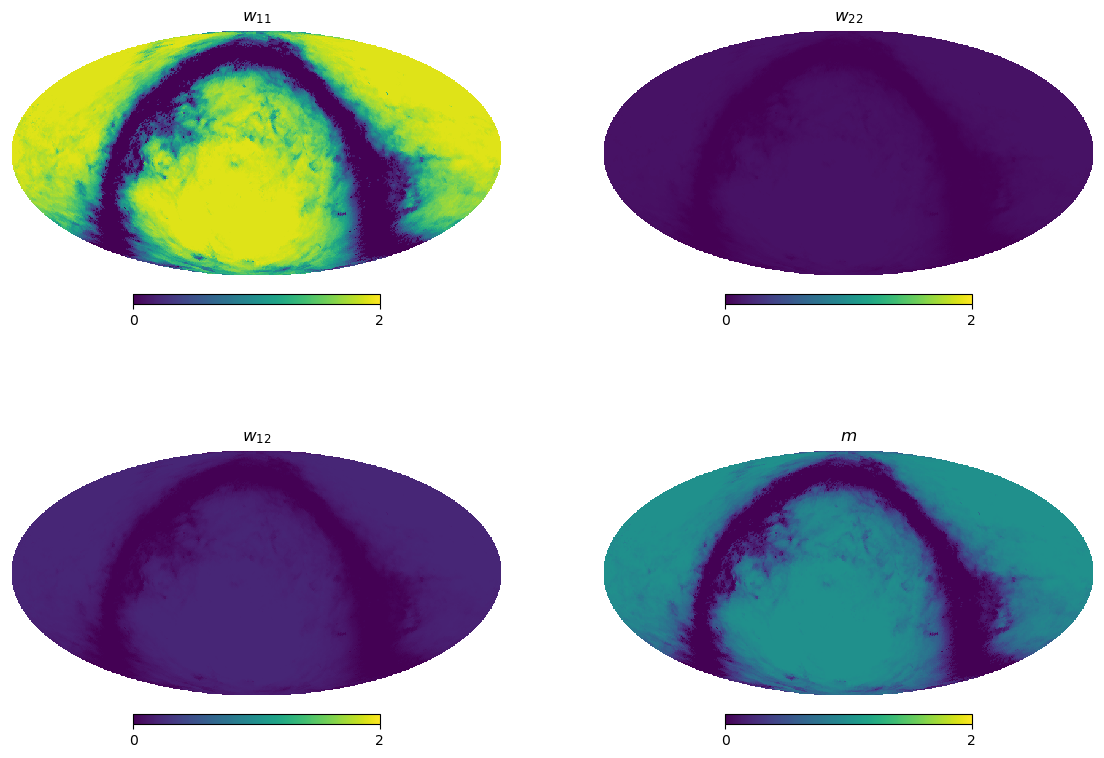

In [2]:
nside = 256
delta_m = 0.9
r_m = 0.5

fname_mask = 'selection_function_NSIDE64_G20.5_zsplit2bin0.fits'
if not os.path.isfile(fname_mask):
    wget.download("https://zenodo.org/records/8098636/files/selection_function_NSIDE64_G20.5_zsplit2bin0.fits?download=1")
mask = hp.ud_grade(hp.read_map(fname_mask), nside_out=256)

mask_11 = (1+delta_m)*mask
mask_22 = (1-delta_m)*mask
mask_12 = r_m*np.sqrt(mask_11*mask_22)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.axes(axes[0][0])
hp.mollview(mask_11, title='$w_{11}$', hold=True, min=0, max=2)
plt.axes(axes[0][1])
hp.mollview(mask_22, title='$w_{22}$', hold=True, min=0, max=2)
plt.axes(axes[1][0])
hp.mollview(mask_12, title='$w_{12}$', hold=True, min=0, max=2)
plt.axes(axes[1][1])
hp.mollview(mask, title='$m$', hold=True, min=0, max=2)

The syntax to generate anisotropically weighted fields is very simple (see below). Once it's been generated, estimating its power spectrum follows the same steps as in the standard case (see previous tutorials).

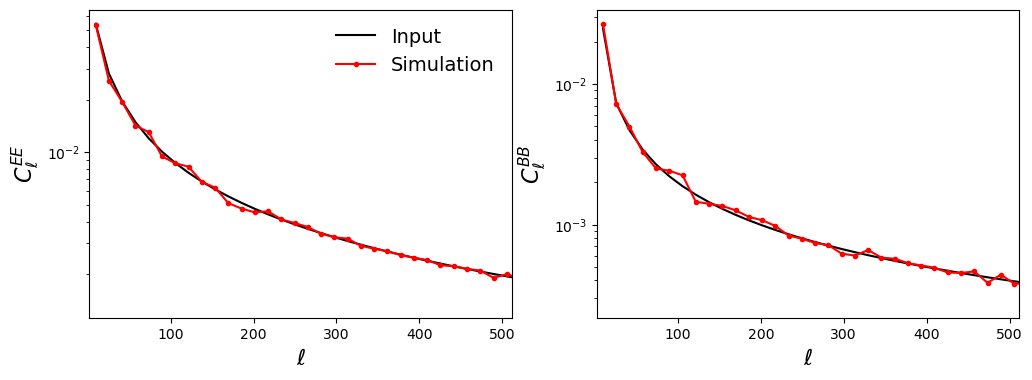

In [3]:
lmax = 3*nside-1
ls = np.arange(lmax+1)
cl_ee = 1/(10+ls)
cl_bb = 0.2/(1+ls)
cl_eb = 0*ls

def get_sim():
    almE, almB = hp.synalm([cl_ee, cl_bb, cl_eb], lmax=lmax, mmax=lmax, new=True)
    mpQ, mpU = hp.alm2map_spin(np.array([almE, almB]), nside, spin=2, lmax=lmax, mmax=lmax)
    f = nmt.NmtField(mask_11, [mpQ, mpU], n_iter=0, mask_12=mask_12, mask_22=mask_22)
    return f

f = get_sim()
b = nmt.NmtBin.from_nside_linear(nside, nlb=16)
w = nmt.NmtWorkspace.from_fields(f, f, b)

leff = b.get_effective_ells()
cl_theory = w.decouple_cell(w.couple_cell([cl_ee, cl_eb, cl_eb, cl_bb]))
cl = w.decouple_cell(nmt.compute_coupled_cell(f, f))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.plot(leff, cl_theory[0], 'k-', label='Input')
ax.plot(leff, cl[0], 'r.-', label='Simulation')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$', fontsize=16)
ax.set_ylabel(r'$C^{EE}_\ell$', fontsize=16)
ax.set_xlim([2, 2*nside])
ax.legend(fontsize=14, frameon=False, loc='upper right')

ax = axes[1]
ax.plot(leff, cl_theory[3], 'k-', label='Input')
ax.plot(leff, cl[3], 'r.-', label='Simulation')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$', fontsize=16)
ax.set_ylabel(r'$C^{BB}_\ell$', fontsize=16)
ax.set_xlim([2, 2*nside]);

## 5.2 Validation <a class="anchor" id="Ss5.2"></a>
To validate the estimator with anisotropic weights, we calculate the power spectrum for 100 simulations generated as described above, and verify that the their average is compatible with the spectrum used to generate the simulations.

In [4]:
# Compute spectra for 100 sims and then their mean and scatter
nsims = 100
cls = []
for i in range(nsims):
    f = get_sim()
    cl = w.decouple_cell(nmt.compute_coupled_cell(f, f))
    cls.append(cl)
cls = np.array(cls)
clm = np.mean(cls, axis=0)
cle = np.std(cls, axis=0)/np.sqrt(nsims)

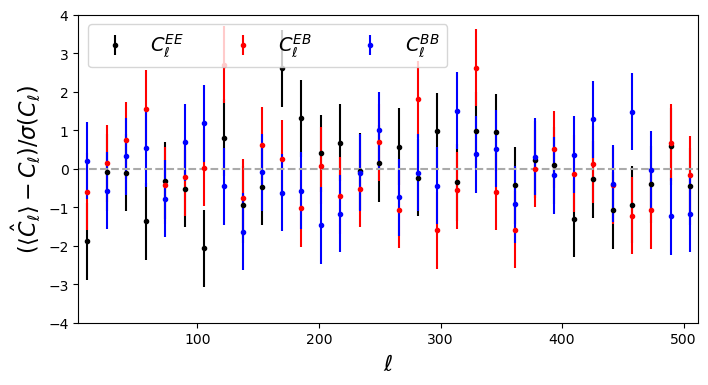

In [5]:
# Plot the results
plt.figure(figsize=(8, 4))
ax = plt.gca()
indices = [0, 1, 3]
names = [r'$C_\ell^{EE}$', r'$C_\ell^{EB}$', r'$C_\ell^{BB}$']
cols = ['k', 'r', 'b']

for ind, name, col in zip(indices, names, cols):
    m = clm[ind]
    e = cle[ind]
    t = cl_theory[ind]
    ax.errorbar(leff, (m-t)/e, yerr=np.ones_like(m),
                fmt=col+'.', label=name)
ax.set_xlabel(r'$\ell$', fontsize=16)
ax.set_ylabel(r'$(\langle \hat{C}_\ell\rangle-C_\ell)/\sigma(C_\ell)$',
              fontsize=16)
ax.set_xlim([2, 2*nside])
ax.set_ylim([-4, 4])
ax.legend(fontsize=14, loc='upper left', ncol=3)
ax.axhline(0, c='#AAAAAA', ls='--')